In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import urllib
import boto3
import string
from io import StringIO
import json
import os


In [133]:
client = boto3.client('textract')

In [139]:
response = client.detect_document_text(Document={'S3Object':
                                                 {'Bucket': 'project-350-warner','Name': 'AllHandwritingImages/w0001_s01_pPHR_r03.png'}})


In [140]:
results = [i['Text'].lower().strip(string.punctuation+'’') for i in response.get('Blocks') if i['BlockType']=='WORD']
results

['the',
 'early',
 'bird',
 'may',
 'get',
 'the',
 'wam',
 'but',
 'the',
 'second',
 'maise',
 'gets',
 'the',
 'cheese']

In [141]:
# Create ground truth of text
london_letter = '''Our  London  business  is  good,  but  Vienna  and  Berlin  are  quiet.   Mr.   D.  Lloyd has gone to Switzerland and I hope for good news.  He will be there for a week at 1496 Zermott Street and then goes to Turin and Rome and will join Colonel Parry and arrive at Athens, Greece, November 27 or December 2.  Letters there should be addressed King James Blvd.  3580.  We expect Charles E. Fuller Tuesday.  Dr.  L. McQuaid and Robert Unger, Esq., left on the ’Y. X.’ Express tonight.'''
london_letter = london_letter.replace('  ',' ')

woz = '''Within a short time she was walking briskly toward the Emerald City, her silver shoes tinkling merrily on the hard, yellow roadbed. The sun shone bright and the birds sang sweet and Dorothy did not feel nearly as bad as you might think a little girl would who had been suddenly whisked away from her own country and set downin the midst of a strange land.'''
woz = woz.replace('  ',' ')

phrase = '''The early bird may get the worm, but the second mouse gets the cheese.'''

In [144]:
ll_words = [i.lower().strip(string.punctuation+'’') for i in london_letter.split(' ')]
ll_df = pd.DataFrame({'word':np.unique(ll_words)})
ll_df['count'] = ll_df.word.apply(ll_words.count)

woz_words = [i.lower().strip(string.punctuation+'’') for i in woz.split(' ')]
woz_df = pd.DataFrame({'word':np.unique(woz_words)})
woz_df['count'] = woz_df.word.apply(woz_words.count)

phr_words = [i.lower().strip(string.punctuation+'’') for i in phrase.split(' ')]
phr_df = pd.DataFrame({'word':np.unique(phr_words)})
phr_df['count'] = phr_df.word.apply(phr_words.count)
phr_df

,word,count
0,bird,1
1,but,1
2,cheese,1
3,early,1
4,get,1
5,gets,1
6,may,1
7,mouse,1
8,second,1
9,the,4


In [146]:
df = pd.DataFrame({'word':np.unique(results)})
df['count'] = df.word.apply(results.count)
df = pd.merge(phr_df,df,on='word',how='left')
df = df.fillna(0)
df['difference'] = abs(df.count_x - df.count_y)
df

,word,count_x,count_y,difference
0,bird,1,1.0,0.0
1,but,1,1.0,0.0
2,cheese,1,1.0,0.0
3,early,1,1.0,0.0
4,get,1,1.0,0.0
5,gets,1,1.0,0.0
6,may,1,1.0,0.0
7,mouse,1,0.0,1.0
8,second,1,1.0,0.0
9,the,4,4.0,0.0


In [30]:
london_letter

'Our London business is good, but Vienna and Berlin are quiet.  Mr.  D. Lloyd has gone to Switzerland and I hope for good news. He will be there for a week at 1496 Zermott Street and then goes to Turin and Rome and will join Colonel Parry and arrive at Athens, Greece, November 27 or December 2. Letters there should be addressed King James Blvd. 3580. We expect Charles E. Fuller Tuesday. Dr. L. McQuaid and Robert Unger, Esq., left on the ’Y. X.’ Express tonight.'

In [147]:
def compare_words(results,ref='london'):
    global ll_df, woz_df, phr_df
    valid_refs = {'london','woz','phrase'}
    if ref not in valid_refs:
        raise ValueError(f"results: status must be one of {valid_refs}")
    
    df_dict = {'london':ll_df,'woz':woz_df,'phrase':phr_df}
    
    df = pd.DataFrame({'word':np.unique(results)})
    df['count'] = df.word.apply(results.count)
    df = pd.merge(df_dict[ref],df,on='word',how='left')
    df = df.fillna(0)
    df['difference'] = abs(df.count_x - df.count_y)
    pct_correct = 1-df.difference.sum()/df.count_x.sum()
    return pct_correct


In [149]:
compare_words(results,'phrase')

0.8571428571428572

In [33]:
s3 = boto3.resource('s3')

In [34]:
bucket = s3.Bucket('project-350-warner')

In [35]:
obj_list = [i.key for i in bucket.objects.all()]
woz_list = [i for i in obj_list if 'pWOZ' in i]
london_list = [i for i in obj_list if 'pLND' in i]
phrase_list = [i for i in obj_list if 'pPHR' in i]
all_imgs = obj_list[1:-21]
all_imgs[:5]

['AllHandwritingImages/w0001_s01_pLND_r01.png',
 'AllHandwritingImages/w0001_s01_pLND_r02.png',
 'AllHandwritingImages/w0001_s01_pLND_r03.png',
 'AllHandwritingImages/w0001_s01_pPHR_r01.png',
 'AllHandwritingImages/w0001_s01_pPHR_r02.png']

In [14]:
obj = bucket.Object(key=obj_list[0])
file = obj.get().get('Body')

In [15]:
csv = file.read().decode('utf-8')
file_df = pd.read_csv(StringIO(csv))
file_df.to_csv('participant_data.csv')

In [16]:
file_df.sort_values('wid').head(10)

,wid,agegroup,gender,hand,thirdgrade_usa,thirdgrade_usa_region,s1_dae,s1_time,s2_dae,s2_time,s3_dae,s3_time
67,1,25-40,female,right,True,midwest,0,earlyafternoon,26,latemorning,47,earlyafternoon
23,2,41-60,male,right,True,midwest,0,latemorning,53,latemorning,98,earlyafternoon
38,3,25-40,female,right,True,midwest,0,earlyafternoon,21,earlyafternoon,47,earlyafternoon
24,4,18-24,female,ambidextrous,True,NaN,0,latemorning,21,earlyafternoon,44,earlymorning
0,5,18-24,male,right,True,midwest,0,latemorning,21,earlyafternoon,42,latemorning
105,6,18-24,male,right,True,midwest,0,earlyevening,42,lateevening,82,earlyevening
60,9,18-24,female,right,True,midwest,0,earlyafternoon,40,earlyafternoon,87,lateevening
65,10,18-24,female,right,True,midwest,0,earlyafternoon,21,earlyafternoon,58,latemorning
14,11,18-24,male,right,True,midwest,0,earlyafternoon,21,earlyafternoon,58,latemorning
114,12,18-24,male,right,True,northeast,0,earlyafternoon,21,earlyafternoon,58,latemorning


In [70]:
# responses = []
results_df = pd.DataFrame({'id':[],'score':[],'avg_conf':[]})
for i in london_list[:100]:
    response = client.detect_document_text(Document={'S3Object':
                                                 {'Bucket': 'project-350-warner','Name': f'{i}'}})
    confs = [j['Confidence'] for j in response.get('Blocks') if j['BlockType']=='WORD']
    words = [j['Text'].lower().strip(string.punctuation+'’') for j in response.get('Blocks') if j['BlockType']=='WORD']
    next_row = pd.DataFrame({'id':[i.split('/')[-1][:-4]],'score':[compare_words(words,'london')],'avg_conf':[np.mean(confs)]})
    results_df = results_df.append(next_row)

In [23]:
results_df.to_csv('prelim_results.csv')
results_df.head()

,id,score,avg_conf,wid,text
0,w0001_s01_pLND_r01,0.875000,93.336228,1,london
0,w0001_s01_pLND_r02,0.886364,92.341743,1,london
0,w0001_s01_pLND_r03,0.863636,92.309366,1,london
0,w0001_s02_pLND_r01,0.863636,92.712618,1,london
0,w0001_s02_pLND_r02,0.840909,92.896059,1,london


In [15]:
# results_df = pd.read_csv('prelim_results.csv')

In [37]:
def match_texts(name):
    name = name.split('_')[2][1:]
    texts = ['london','woz','phrase']
    if name=='LND':
        return texts[0]
    elif name=='WOZ':
        return texts[1]
    elif name=='PHR':
        return texts[2]

In [21]:
results_df['wid'] = results_df.id.apply(lambda x: int(x.split('_')[0][1:]))
results_df['text'] = results_df.id.apply(match_texts)

In [106]:
df2 = final_df.groupby('wid')[['score','avg_conf']].mean()
df3 = pd.read_csv('participant_data.csv')
df3 = pd.merge(df3,df2,on='wid',how='left')
df3 = file_df[file_df.score.notna()]

KeyError: 'wid'

In [56]:
# file_df.sort_values('wid').head(7)
df3.groupby('gender').score.mean()


gender
female    0.810967
male      0.742929
Name: score, dtype: float64

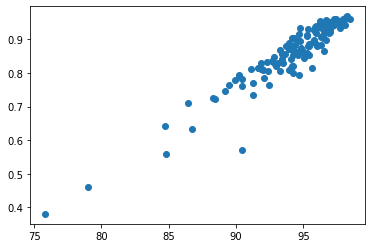

In [152]:
plt.plot(df3.avg_conf,df3.score,'o')

In [156]:
# response = client.detect_document_text(Document={'S3Object':
#                                                  {'Bucket': 'project-350-warner','Name': f'{london_list[10]}'}})
# results = [j['Text'] for j in response.get('Blocks') if j['BlockType']=='LINE']
# results

In [44]:
# file_dict = {}
# for i in all_imgs[:10]:
#     resp = client.detect_document_text(Document={'S3Object':
#                                                  {'Bucket': 'project-350-warner','Name': f'{i}'}})
#     file_dict.update({i.split('/')[-1][:-4]:resp})

# with open("responses_test.json", "w") as outfile:
#     json.dump(file_dict, outfile)

In [29]:
import os
# os.chdir('final_project_files')
os.listdir()
os.getcwd()


'/home/ec2-user/SageMaker/final_project_files'

In [30]:
with open('responses.json') as file:
    file_json = json.load(file)

In [42]:
split_idx = len(file_json.keys())//2
d1 = dict(list(file_json.items())[:split_idx])
d2 = dict(list(file_json.items())[split_idx:])

In [43]:
with open("responses2.json", "w") as outfile:
    json.dump(d1, outfile)

In [38]:
def responses_to_df(resp):
    df = pd.DataFrame({'id':[],'score':[],'avg_conf':[],'text':[]})
    for i,j in resp.items():
        confs = [k['Confidence'] for k in j.get('Blocks') if k['BlockType']=='WORD']
        words = [k['Text'].lower().strip(string.punctuation+'’') for k in j.get('Blocks') if k['BlockType']=='WORD']
        next_row = pd.DataFrame({'id':[i],'score':[compare_words(words,match_texts(i))],'avg_conf':[np.mean(confs)],'text':[match_texts(i)]})
        df = df.append(next_row)
    df['wid'] = df.id.apply(lambda x: int(x.split('_')[0][1:]))
    return df

In [39]:
final_df = responses_to_df(file_json)

In [40]:
final_df

,id,score,avg_conf,text,wid
0,w0001_s01_pLND_r01,0.875000,93.336228,london,1
0,w0001_s01_pLND_r02,0.886364,92.341743,london,1
0,w0001_s01_pLND_r03,0.863636,92.309366,london,1
0,w0001_s01_pPHR_r01,0.928571,97.852685,phrase,1
0,w0001_s01_pPHR_r02,0.928571,94.600888,phrase,1
...,...,...,...,...,...
0,w0342_s03_pPHR_r02,0.928571,95.790870,phrase,342
0,w0342_s03_pPHR_r03,0.642857,95.321429,phrase,342
0,w0342_s03_pWOZ_r01,0.772727,91.843423,woz,342
0,w0342_s03_pWOZ_r02,0.787879,91.710987,woz,342


In [150]:
df2 = final_df.groupby('wid')[['score','avg_conf']].mean()
df3 = pd.read_csv('participant_data.csv')
df3['gender'] = df3.gender.apply(lambda x: x.lower())
df3['hand'] = df3.hand.apply(lambda x: x.lower())
df3 = df3[df3.s1_time.notna()]
df3 = df3[df3.s2_time.notna()]
df3 = df3[df3.s3_time.notna()]
df3['s1_time'] = df3.s1_time.apply(lambda x: x.replace(' ','').lower())
df3['s2_time'] = df3.s2_time.apply(lambda x: x.replace(' ','').lower())
df3['s3_time'] = df3.s3_time.apply(lambda x: x.replace(' ','').lower())

df3 = pd.merge(df3,df2,on='wid',how='left')
df3 = df3[df3.score.notna()]
df3 = df3[df3.wid!=203]


In [156]:
df3.groupby('gender')[['score','avg_conf']].mean()

,score,avg_conf
gender,,
female,0.882276,94.863717
male,0.827675,93.193811


In [99]:
df3.sort_values('score').head(20)

,Unnamed: 0,wid,agegroup,gender,hand,thirdgrade_usa,thirdgrade_usa_region,s1_dae,s1_time,s2_dae,s2_time,s3_dae,s3_time,score,avg_conf
132,132,31,41-60,male,right,True,midwest,0,lateevening,22,earlyevening,43,lateevening,0.380672,75.837956
23,23,2,41-60,male,right,True,midwest,0,latemorning,53,latemorning,98,earlyafternoon,0.460358,78.988877
11,11,82,41-60,male,right,True,midwest,0,lateafternoon,32,earlyafternoon,82,lateafternoon,0.557463,84.773655
7,7,29,41-60,female,right,True,midwest,0,earlymorning,47,lateevening,97,earlymorning,0.569565,90.419055
98,98,30,18-24,male,right,True,midwest,0,NaN,23,latemorning,54,lateafternoon,0.585257,81.688992
24,24,4,18-24,female,ambidextrous,True,NaN,0,latemorning,21,earlyafternoon,44,earlymorning,0.634079,86.742605
47,47,123,18-24,male,right,True,south,0,latemorning,21,earlyafternoon,42,earlyafternoon,0.641026,84.734780
106,106,85,25-40,male,right,True,midwest,0,earlyevening,27,lateafternoon,59,lateevening,0.711199,86.390806
0,0,5,18-24,male,right,True,midwest,0,latemorning,21,earlyafternoon,42,latemorning,0.722527,88.422249
99,99,151,18-24,female,right,True,midwest,0,lateevening,23,lateevening,44,lateevening,0.723886,88.306278


In [79]:
file_df[file_df.wid==203]

,wid,agegroup,gender,hand,thirdgrade_usa,thirdgrade_usa_region,s1_dae,s1_time,s2_dae,s2_time,s3_dae,s3_time
69,203,25-40,Female,Right,False,NaN,0,Early Afternoon,60,Late Morning,129,Late Afternoon
